# Initial Setup

In [1]:
from datetime import datetime as dt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import statistics as stats
from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
#set up matplotlib
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (30, 15),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

# constants
MOVING_AVERAGE_WINDOW_SIZE = 10
PREDICTION_WINDOW_SIZE = 50
EPOCH = 100
BATCH_SIZE = 30
LSTM_UNITS = 60
DROPOUT = 0.2
NUM_LSTM_LAYERS = 4

# Utility Functions

In [3]:
def show_graph(data):
    plt.plot(data['Open'])
    plt.xlabel('Date')
    plt.ylabel('Open')
    plt.title('Trend of DJIA Open')
    plt.show()
     
def get_trend(data):
    return [data[i - 1] < data[i] for i in range(1, len(data))]

def get_moving_averages(data, window_size):
    return [stats.mean(data[i: i + window_size]) for i in range(len(data) - window_size)]

def get_moving_window_dataframes(data, window_size):
    averages, trends = pd.DataFrame(), pd.DataFrame()
    for column in list(data):
        averages[column] = get_moving_averages(data[column], window_size)
        trends[column] = get_trend(averages[column]) if column != 'Open' else averages[column][1:]
    return averages, trends

def split_to_prediction_windows(data, prediction_window, use_all_predictors):
    x = []
    y = []
    for i in range(prediction_window, len(data)):
        x.append(data[i - prediction_window: i, :] if use_all_predictors else data[i - prediction_window: i, 0])
        y.append(data[i, 0])
    x = np.array(x)
    x = x.reshape(x.shape[0], x.shape[1], 6 if use_all_predictors else 1)
    return x, np.array(y)

def generate_train_test_prediction_windows(train, test, prediction_window_size, use_all_predictors):
    x_train, y_train = split_to_prediction_windows(train, prediction_window_size, use_all_predictors)
    x_test, y_test = split_to_prediction_windows(test, prediction_window_size, use_all_predictors)
    return x_train, y_train, x_test, y_test

def inverse_transform_single_column(scaler, y_values):
    return scaler.inverse_transform(np.array([[y, 0, 0, 0, 0, 0] for y in y_values]))[:, 0]

def train_model(x_train, y_train, units, dropout, num_lstm_layers):
    model = Sequential(
        [
            LSTM(units, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])),
            Dropout(dropout)
        ] +
        [
            LSTM(units, return_sequences=True),
            Dropout(dropout)
        ] * (num_lstm_layers - 2) +
        [
            LSTM(units),
            Dropout(dropout),
            Dense(1)
        ])
    model.compile(optimizer='rmsprop',loss='mean_squared_error')
    history = model.fit(x_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE)
    return model, history

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()
    
def plot_prediction(scaler, x_test, y_test, model):
    y_predict = model.predict(x_test)
    plt.plot(inverse_transform_single_column(scaler, y_test), color='blue',label='Real DJIA')
    plt.plot(inverse_transform_single_column(scaler, y_predict), color='red',label='Predicted DJIA')
    plt.title('DJIA Prediction')
    plt.xlabel('Time')
    plt.ylabel('DJIA')
    plt.legend()
    plt.show()

# Data Cleaning

In [4]:
djia = pd.read_csv('djia.csv', index_col='Date', parse_dates=['Date'], date_parser=lambda date: dt.strptime(date,'%d/%m/%Y').date())

In [5]:
djia.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1985-01-29,1277.719971,1295.489990,1266.890015,1292.619995,1292.619995,13560000
1985-01-30,1297.369995,1305.099976,1278.930054,1287.880005,1287.880005,16820000
1985-01-31,1283.239990,1293.400024,1272.640015,1286.770020,1286.770020,14070000
1985-02-01,1276.939941,1286.109985,1269.770020,1277.719971,1277.719971,10980000
1985-02-04,1272.079956,1294.939941,1268.989990,1290.079956,1290.079956,11630000


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


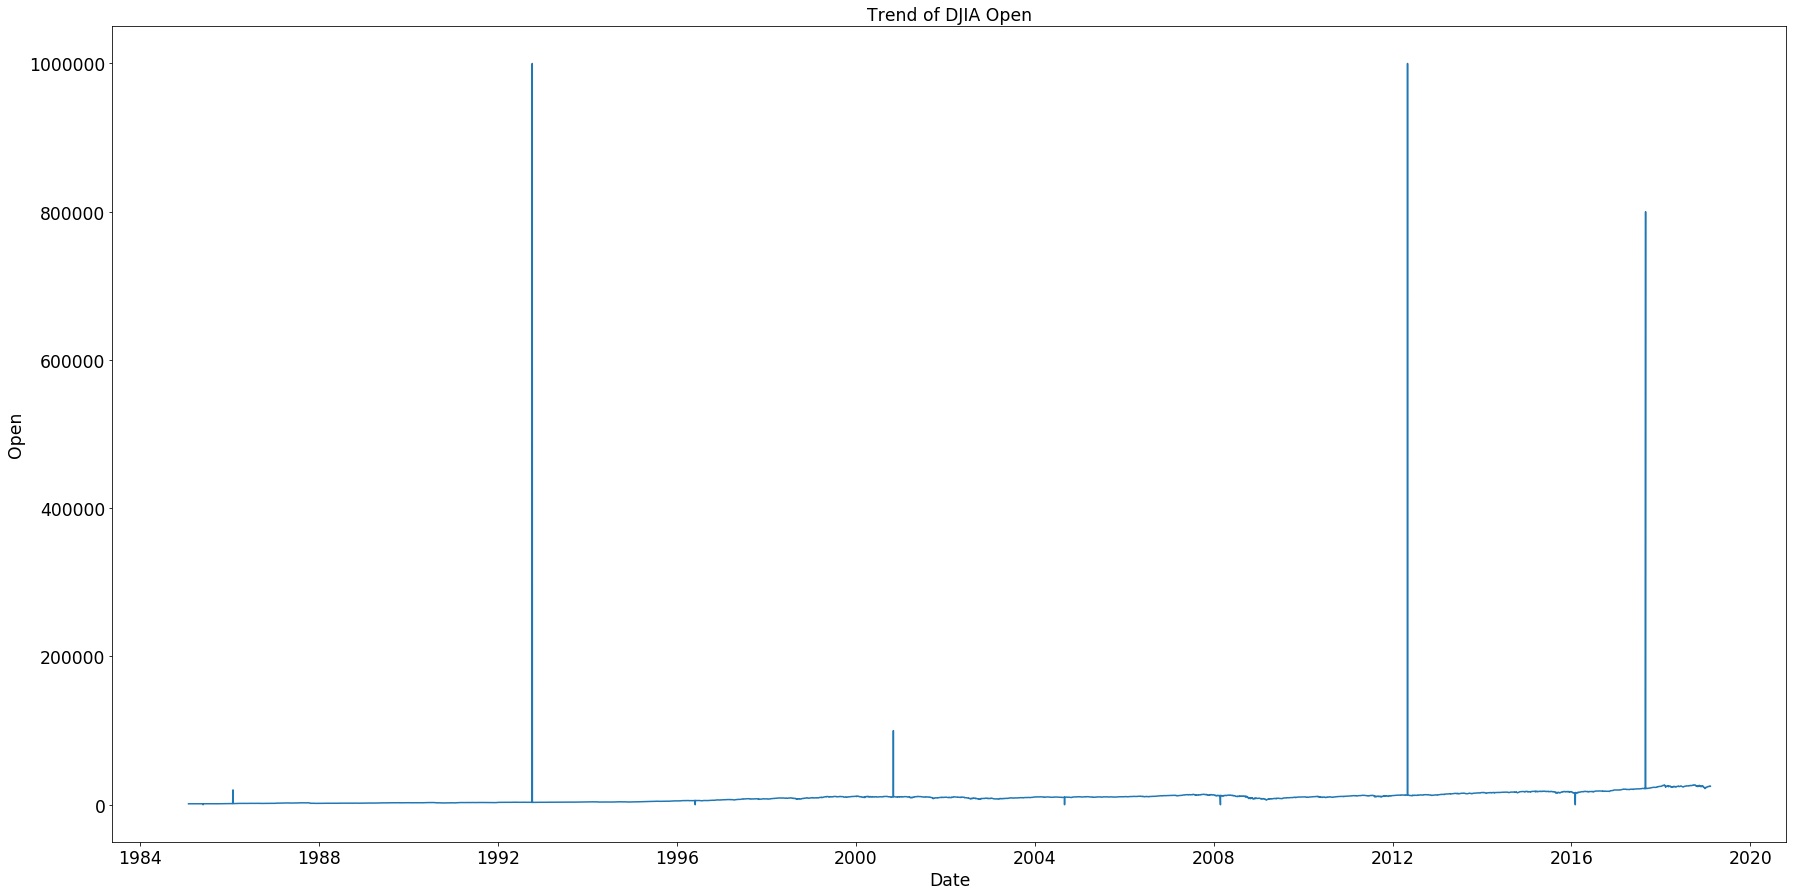

In [6]:
show_graph(djia)

In [7]:
# remove outliers and bad data
djia = djia[(djia['Open'] < 60000) & (djia['Open'] > 0) & (djia['High'] > djia['Low'])]

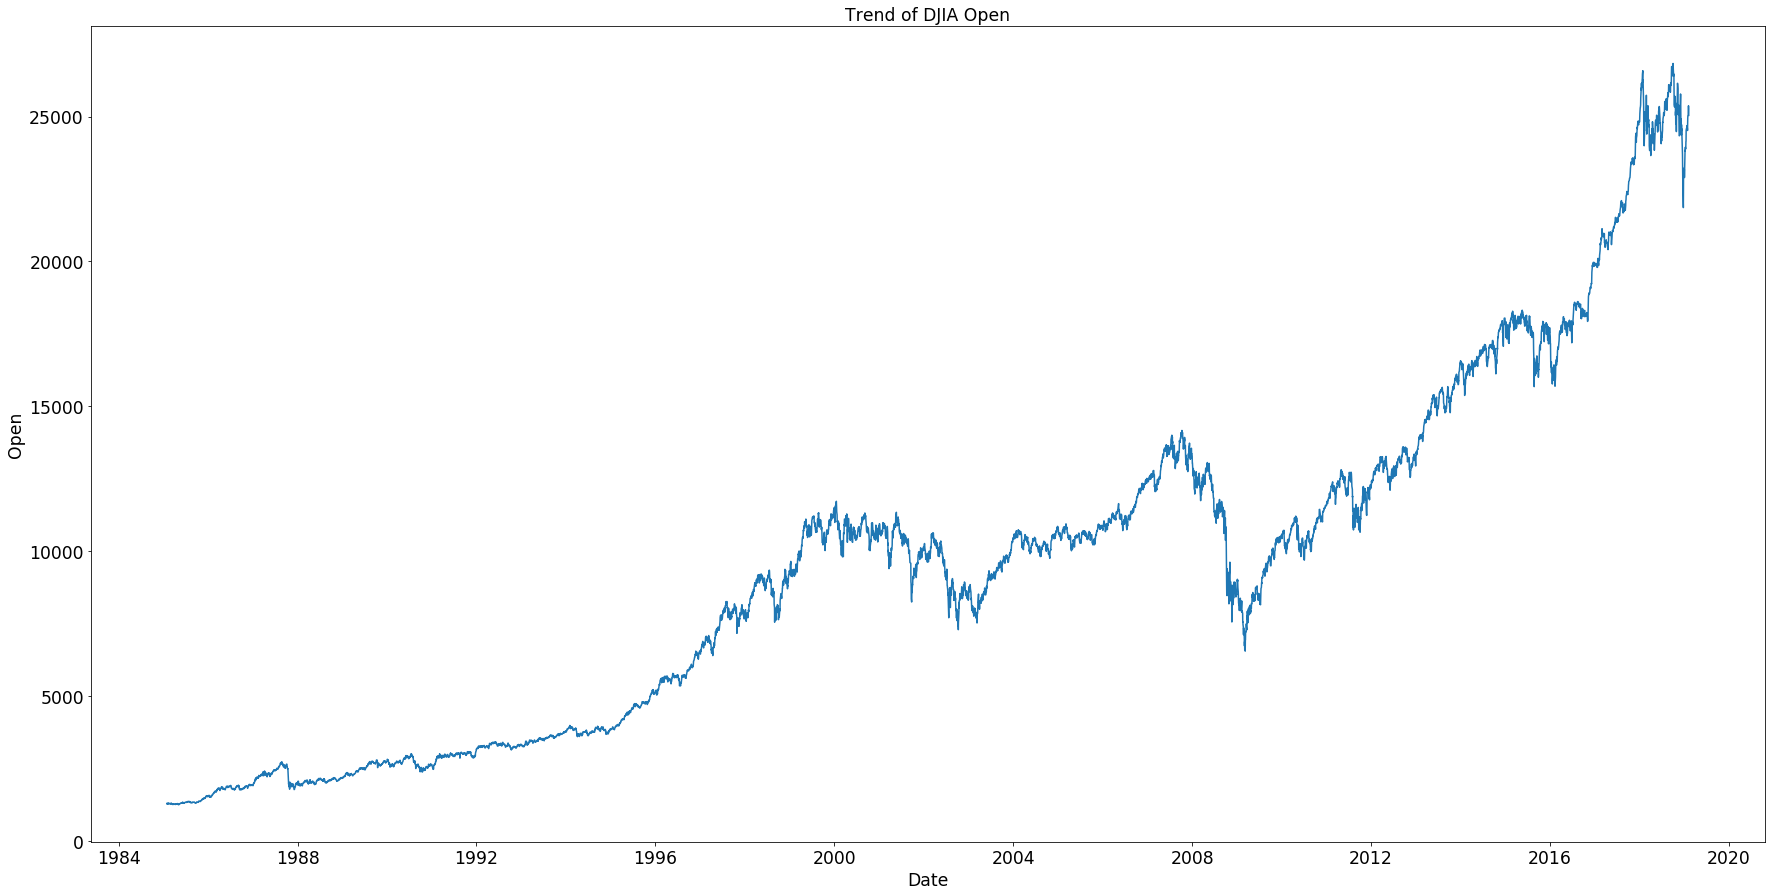

In [8]:
show_graph(djia)

In [9]:
averages, trends = get_moving_window_dataframes(djia, MOVING_AVERAGE_WINDOW_SIZE)

In [10]:
averages.head()

,Open,High,Low,Close,Adj Close,Volume
0,1284.936987,1295.659997,1274.072009,1285.699988,1285.699988,12751000
1,1284.284985,1294.423999,1274.017004,1284.098987,1284.098987,12582000
2,1282.330981,1294.380005,1273.575000,1285.102991,1285.102991,12305000
3,1284.185986,1295.793005,1274.679004,1285.213989,1285.213989,12300000
4,1285.411987,1296.809009,1275.208997,1285.643994,1285.643994,12075000


In [11]:
trends.head()

,Open,High,Low,Close,Adj Close,Volume
1,1284.284985,False,False,False,False,False
2,1282.330981,False,False,True,True,False
3,1284.185986,True,True,True,True,False
4,1285.411987,True,True,True,True,False
5,1286.184998,False,True,False,False,False


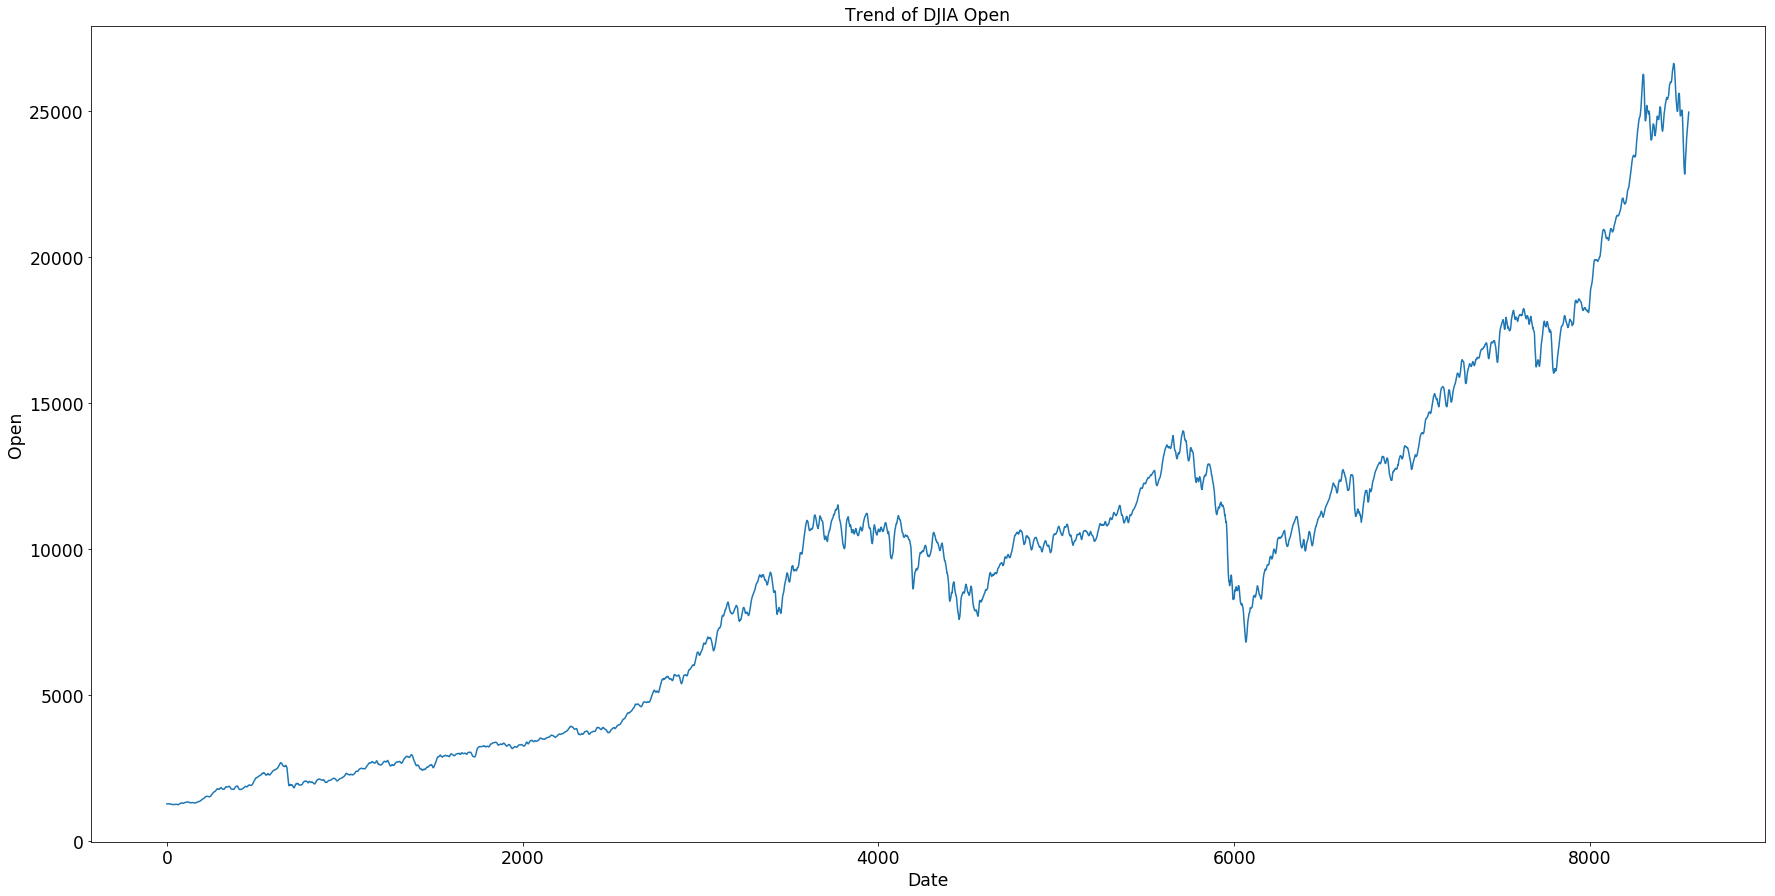

In [12]:
show_graph(averages)

In [13]:
scaler = MinMaxScaler(feature_range=(0,1))
djia_matrix = scaler.fit_transform(averages[-1000:])
djia_matrix_train = djia_matrix[:700]
djia_matrix_test = djia_matrix[700:]

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


# Trend Predictors Model

In [14]:
trend_scaler = MinMaxScaler(feature_range=(0,1))
trends = trends[-1000:]
trends[['Open']] = trend_scaler.fit_transform(trends[['Open']])
djia_trends = trends.values
djia_trends_train = djia_trends[:700]
djia_trends_test = djia_trends[700:]

In [15]:
x_train, y_train, x_test, y_test = generate_train_test_prediction_windows(djia_trends_train, djia_trends_test, PREDICTION_WINDOW_SIZE, True)
model_trend_predictors, history_trend_predictors = train_model(x_train, y_train, LSTM_UNITS, DROPOUT, NUM_LSTM_LAYERS)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
650/650 [==============================] - 4s 6ms/step - loss: 0.0356
Epoch 2/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0166
Epoch 3/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0089
Epoch 4/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0080
Epoch 5/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0057
Epoch 6/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0063
Epoch 7/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0052
Epoch 8/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0045
Epoch 9/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0046
Epoch 10/100
650/650 [=====

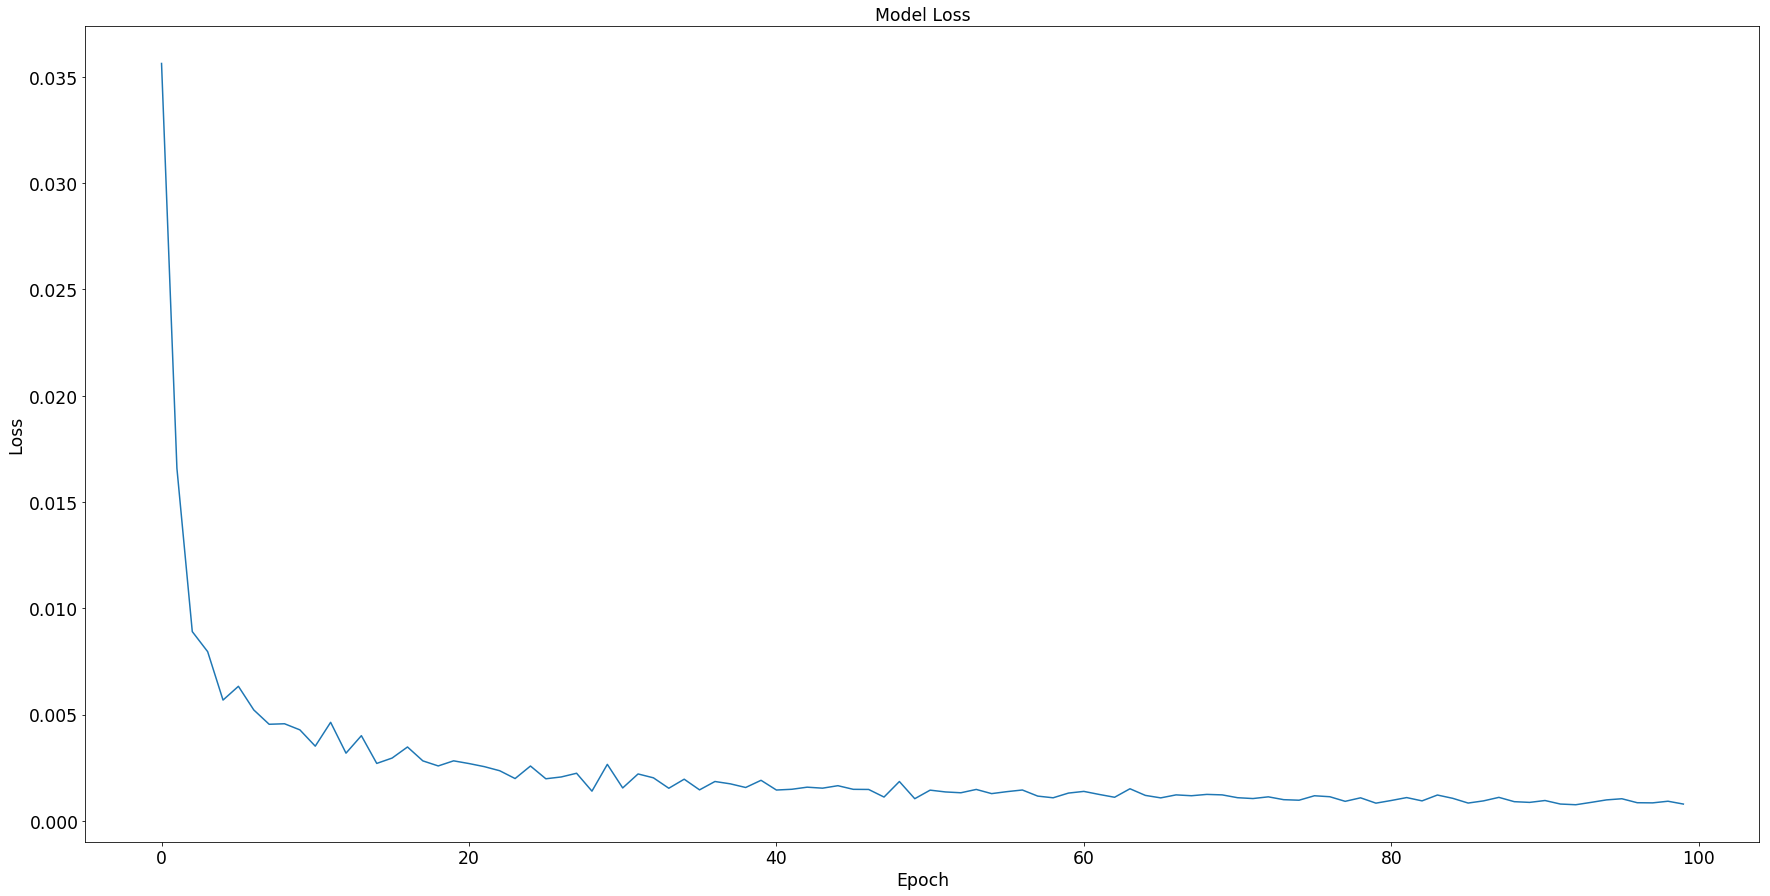

In [16]:
plot_loss(history_trend_predictors)

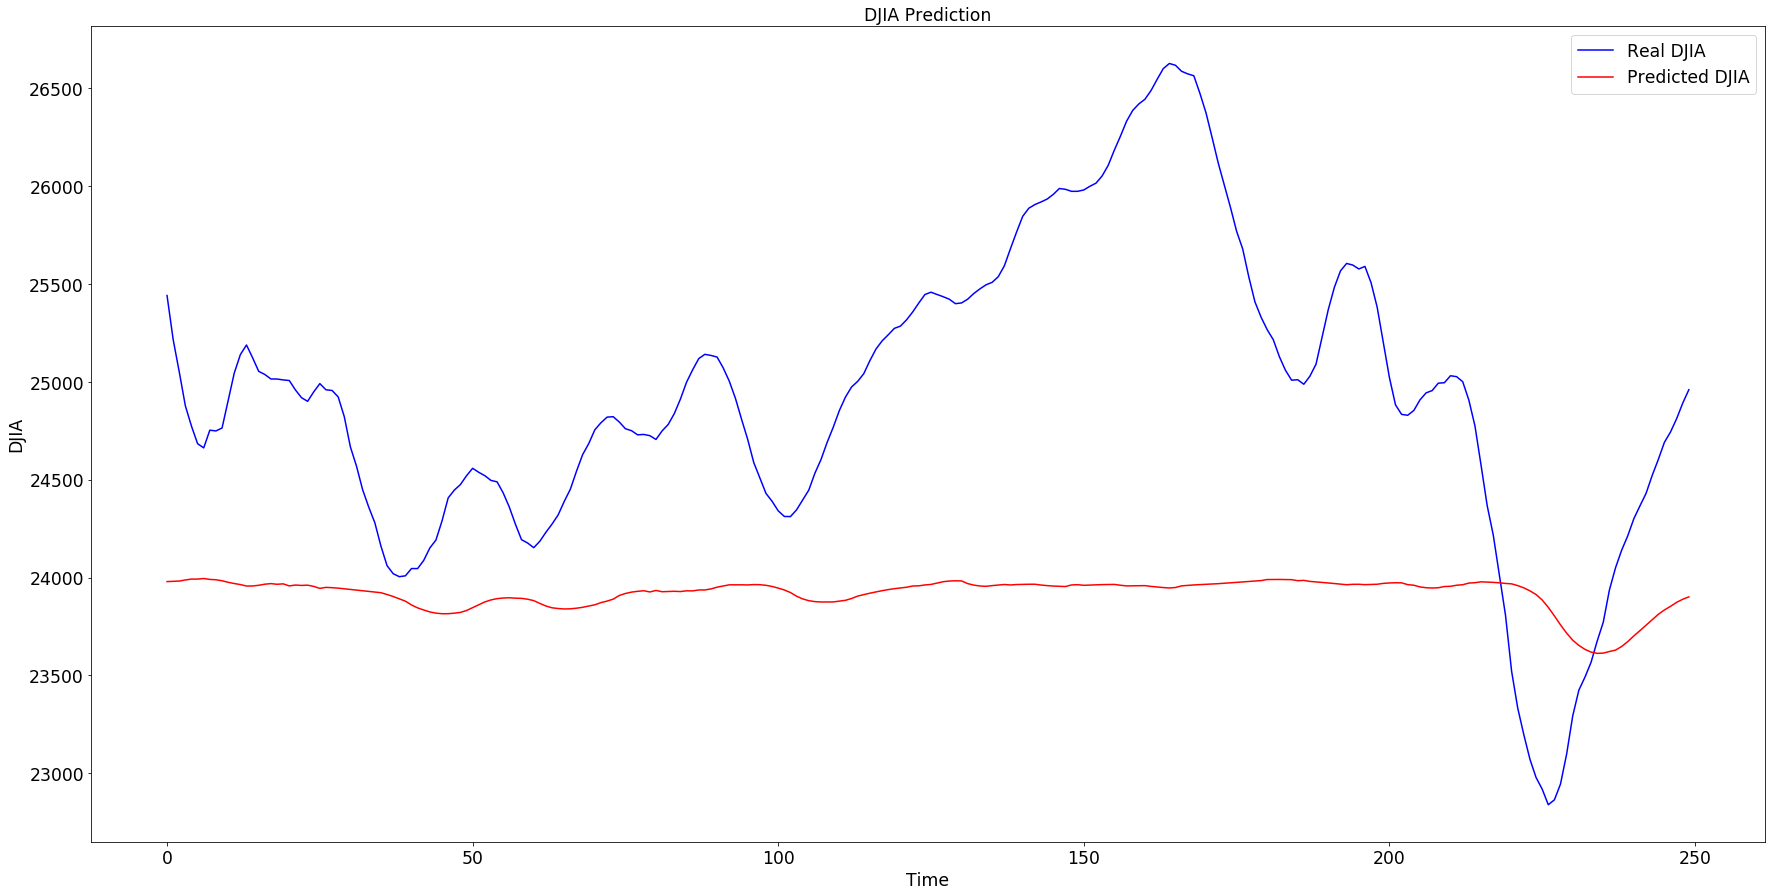

In [17]:
plot_prediction(trend_scaler, x_test, y_test, model_trend_predictors)

# All Predictors Model

In [18]:
x_train, y_train, x_test, y_test = generate_train_test_prediction_windows(djia_matrix_train, djia_matrix_test, PREDICTION_WINDOW_SIZE, True)
model_all_predictors, history_all_predictors = train_model(x_train, y_train, LSTM_UNITS, DROPOUT, NUM_LSTM_LAYERS)

Epoch 1/100
650/650 [==============================] - 5s 7ms/step - loss: 0.0165
Epoch 2/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0064
Epoch 3/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0062
Epoch 4/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0041
Epoch 5/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0041
Epoch 6/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0044
Epoch 7/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0047
Epoch 8/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0034
Epoch 9/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0033
Epoch 10/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0032
Epoch 11/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0029
Epoch 12/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0025
Epoch 13/100


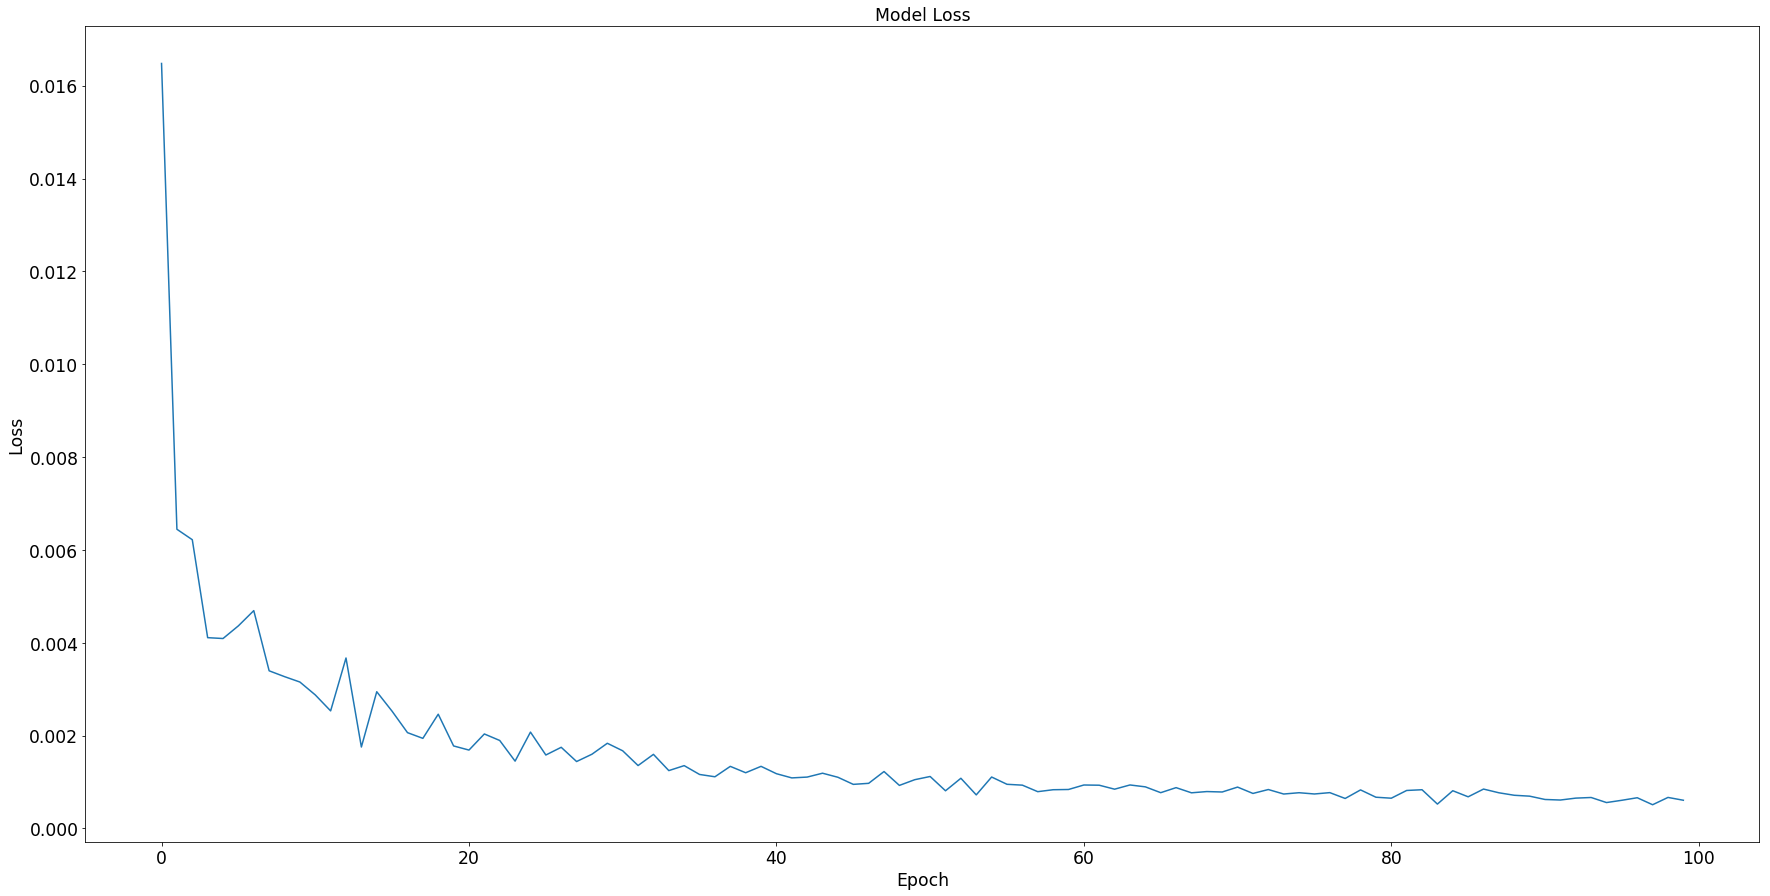

In [19]:
plot_loss(history_all_predictors)

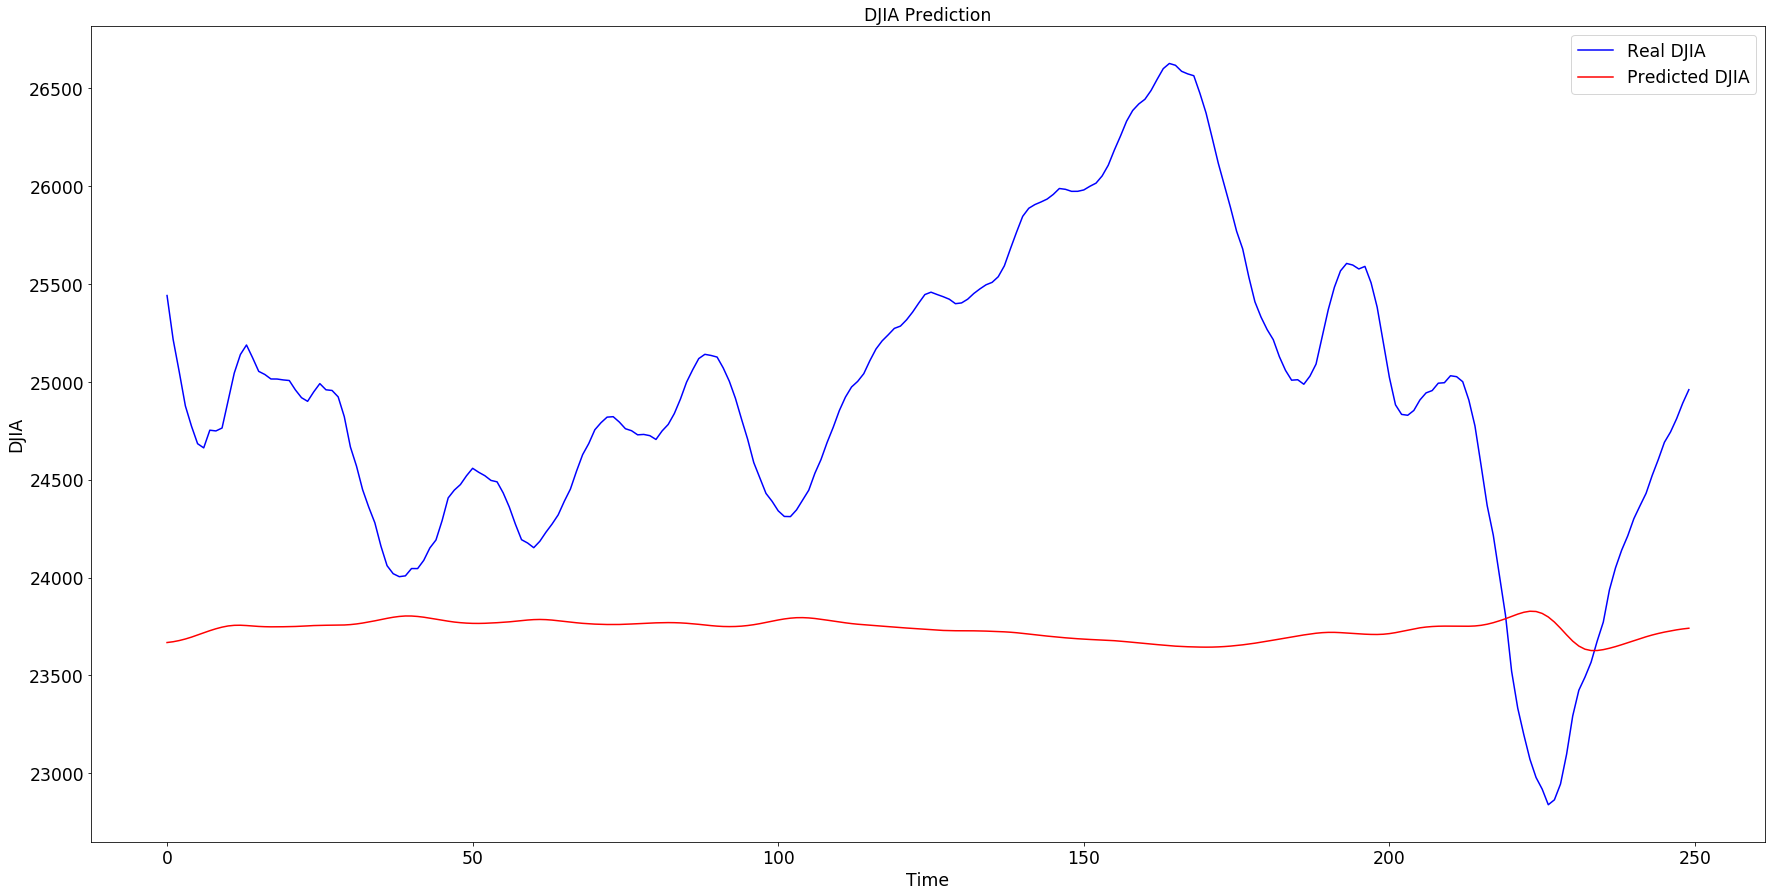

In [20]:
plot_prediction(scaler, x_test, y_test, model_all_predictors)

# Open Predictor Model

In [21]:
x_train, y_train, x_test, y_test = generate_train_test_prediction_windows(djia_matrix_train, djia_matrix_test, PREDICTION_WINDOW_SIZE, False)
model, history = train_model(x_train, y_train, LSTM_UNITS, DROPOUT, NUM_LSTM_LAYERS)

Epoch 1/100
650/650 [==============================] - 5s 8ms/step - loss: 0.0197
Epoch 2/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0054
Epoch 3/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0047
Epoch 4/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0063
Epoch 5/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0044
Epoch 6/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0038
Epoch 7/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0040
Epoch 8/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0039
Epoch 9/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0030
Epoch 10/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0037
Epoch 11/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0030
Epoch 12/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0028
Epoch 13/100


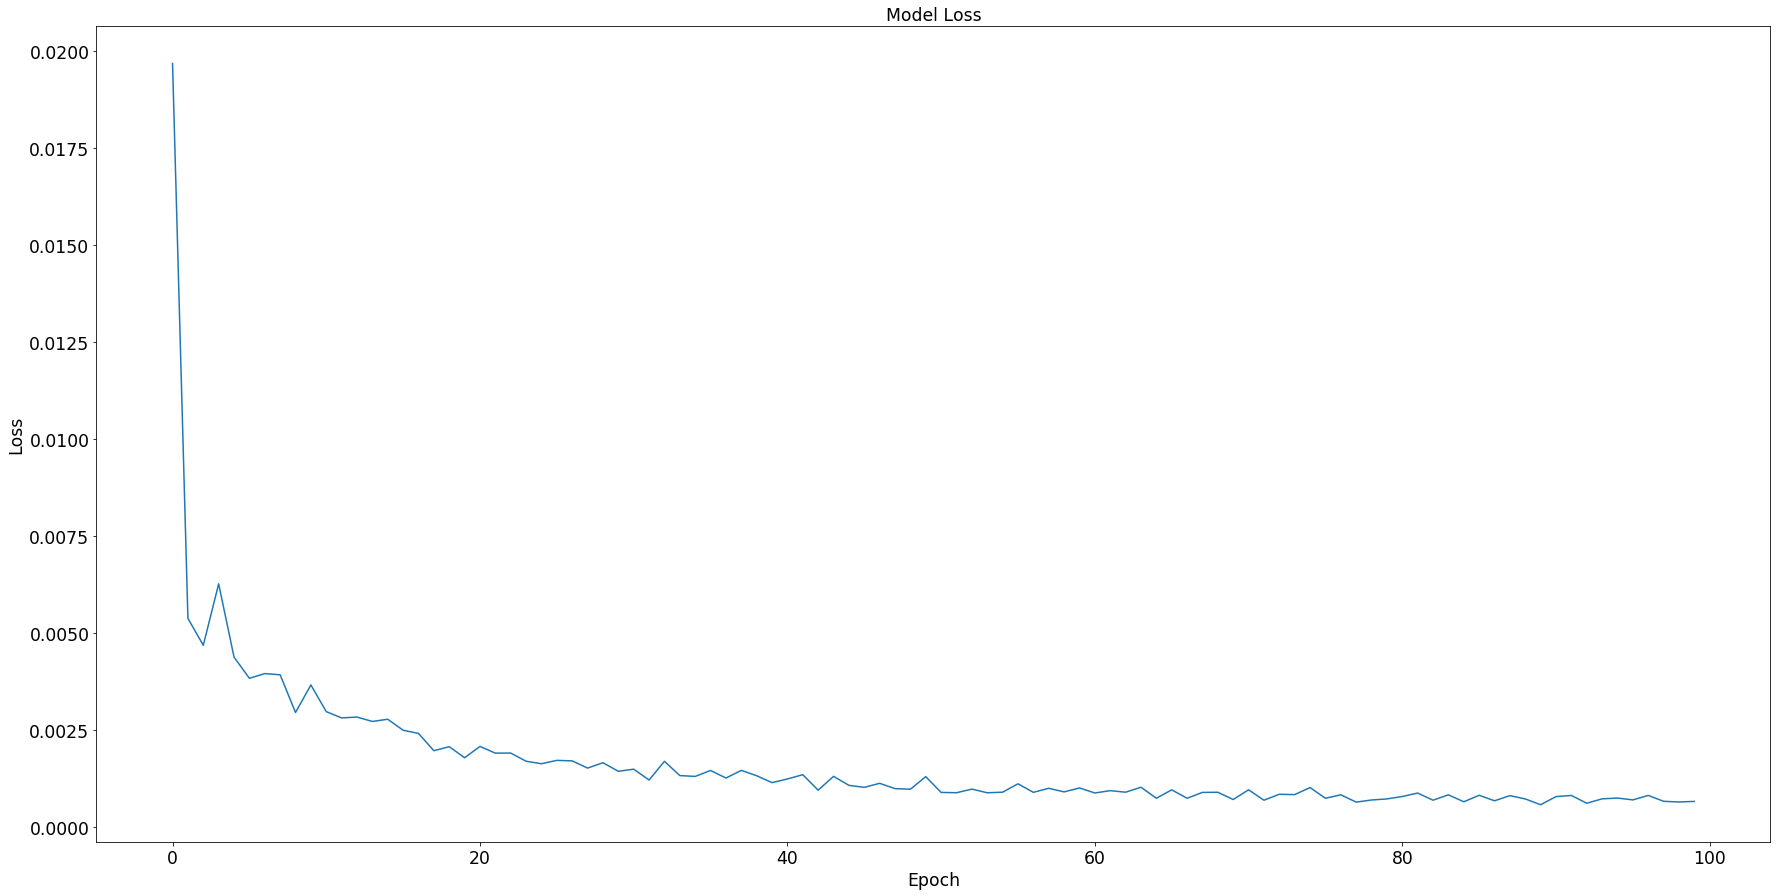

In [22]:
plot_loss(history)

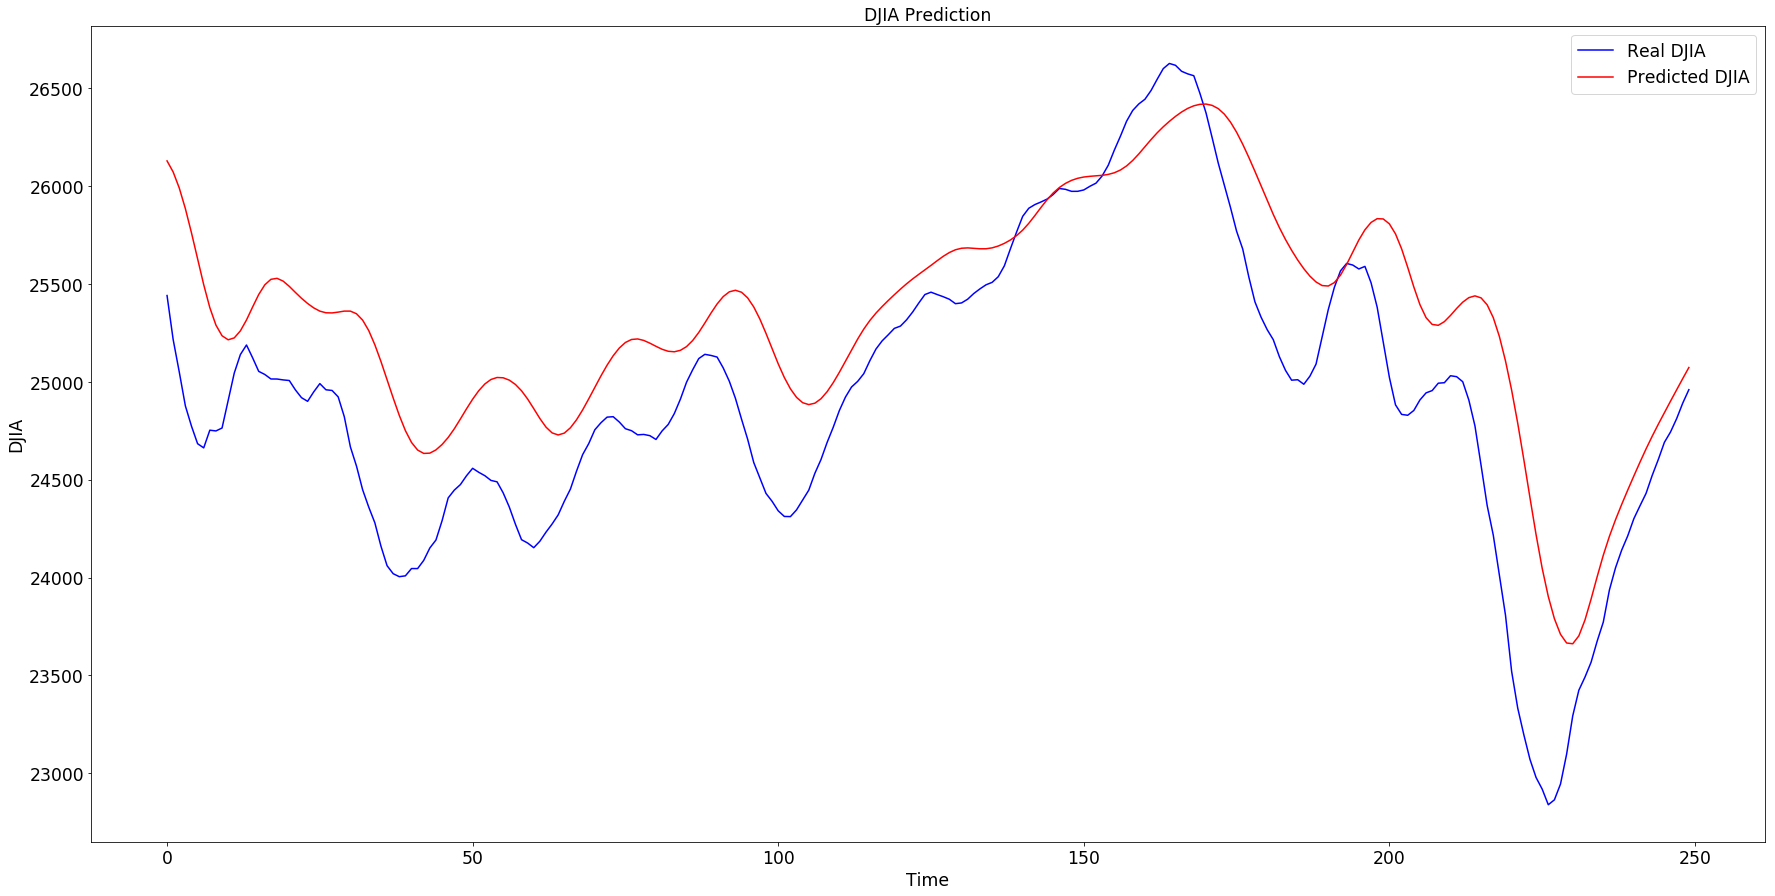

In [23]:
plot_prediction(scaler, x_test, y_test, model)